# System dynamics

$\pi_{i,t} = \tau_{i,t} + \delta_{i,1,t} \cdot seas_1(t) + \ldots + \delta_{i,4,t} \cdot seas_4(t) + \eta_{i,t}$

$\tau_{i,t} = \tau_{i,t-1}  + \epsilon_{i,t}$

$\delta_{i,j,t} = \delta_{i,j,t-1} + seas_j(t) \cdot \xi_{i,t},\quad i = 1,2,3,4$

(after each step, subtract mean from deltas to get 0 delta mean.)

$\eta_t \sim \mathcal{N}(\mathbb{0}, \sigma_{\eta,t}^2)$

$\epsilon_t \sim \mathcal{N}(\mathbb{0}, \sigma_{\epsilon,t}^2)$

$\ln \sigma_{\eta,t}^2 = \ln \sigma_{\eta,t-1}^2 + \nu_{\eta, t}$

$\ln \sigma_{\epsilon,t}^2 = \ln \sigma_{\epsilon,t-1}^2 + \nu_{\epsilon, t}$

where $seas_i(t) = 1$ iff the season corresponding to timestamp $t$ is $i$.

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# env XLA_FLAGS=--xla_force_host_platform_device_count=12 python foo.py
os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'

import jax
jax.config.update('jax_platform_name', 'cpu')
jax.devices()

I0000 00:00:1712318198.503350 4026563 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0),
 CpuDevice(id=1),
 CpuDevice(id=2),
 CpuDevice(id=3),
 CpuDevice(id=4),
 CpuDevice(id=5),
 CpuDevice(id=6),
 CpuDevice(id=7),
 CpuDevice(id=8),
 CpuDevice(id=9),
 CpuDevice(id=10),
 CpuDevice(id=11),
 CpuDevice(id=12),
 CpuDevice(id=13),
 CpuDevice(id=14),
 CpuDevice(id=15),
 CpuDevice(id=16),
 CpuDevice(id=17),
 CpuDevice(id=18),
 CpuDevice(id=19),
 CpuDevice(id=20),
 CpuDevice(id=21),
 CpuDevice(id=22),
 CpuDevice(id=23)]

In [3]:
import pandas as pd
from seminartools.data import read_inflation
from seminartools.models.mucsvss_model import MUCSVSSModel

# 1. Read data

In [4]:
df_inflation = read_inflation(mergeable_format=True).reset_index()
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


# 2. Model

In [5]:
model = MUCSVSSModel(
    num_particles=100008, stochastic_seasonality=True
)
model.load_from_disk("../../models/mucsvss_model_100008.parquet")

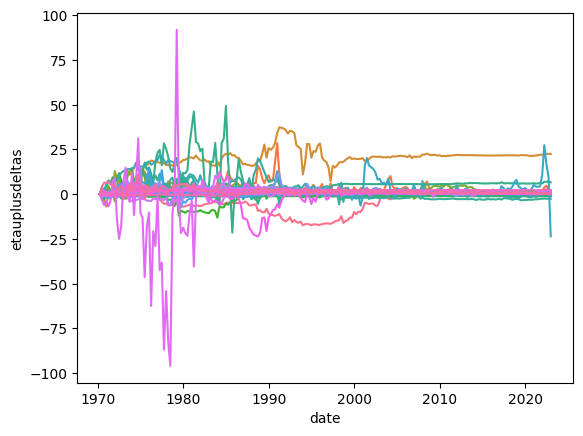

In [6]:
import seaborn as sns
import matplotlib.pyplot as plt
# color is country
sns.lineplot(data = model.stored_state_means["etauplusdeltas"].reset_index(), x = "date", y = "etauplusdeltas", hue = "country")
plt.legend().remove()

In [7]:
import seaborn as sns
# 2 decimals. thin column width
model.corr.style.format(precision = 2).background_gradient(cmap='coolwarm', axis=None)

,Portugal,New Zealand,Dominican Republic,Finland,Ireland,Austria,Japan,South Africa,Korea,Fiji,Paraguay,Malaysia,Sweden,Switzerland,Thailand,Cyprus,Mauritius,Greece,France,Denmark,Netherlands,Türkiye,Singapore,Germany,Luxembourg,Guatemala,Norway,Belgium,United States,Canada,Italy,United Kingdom,Australia,Spain,Philippines
Portugal,1.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.00,0.00,0.00,0.00,0.04,0.00,0.01,0.00,0.00,0.01,0.02,0.00,0.00,0.02,0.00,0.00,0.01,0.03,0.00,0.48,0.00
New Zealand,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Dominican Republic,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Finland,0.00,0.00,0.00,1.00,0.01,0.04,0.00,0.00,0.00,0.00,0.00,0.00,0.60,0.01,0.00,0.00,0.00,0.00,0.01,0.19,0.03,0.01,0.00,0.04,0.02,0.00,0.24,0.02,0.00,0.00,0.00,0.01,0.00,0.00,0.00
Ireland,0.02,0.00,0.00,0.01,1.00,0.02,0.00,0.00,0.00,0.00,0.00,0.00,0.02,0.08,0.00,0.00,0.00,0.00,0.25,0.07,0.26,0.00,0.00,0.17,0.16,0.00,0.07,0.25,0.00,0.00,0.01,0.53,0.00,0.04,0.00
Austria,0.00,0.00,0.00,0.04,0.02,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.07,0.31,0.00,0.01,0.00,0.06,0.13,0.20,0.17,0.07,0.00,0.26,0.26,0.00,0.05,0.18,0.00,0.00,0.26,0.07,0.00,0.01,0.00
Japan,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.09,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
South Africa,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Korea,0.00,0.00,0.00,0.00,0.00,0.00,0.09,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
Fiji,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


In [8]:
model.stored_state_means

etau  etauplusdeltas  elnsetasq  esigmaeta  \
country     date                                                         
Portugal    1970-04-01  0.014149        0.005166   2.432762   3.374952   
            1970-07-01  0.014654        1.917321   2.571841   3.617996   
            1970-10-01  0.021784        1.330174   2.713829   3.884191   
            1971-01-01  0.019081        2.198264   2.629468   3.723760   
            1971-04-01  0.021656        1.902301   2.512504   3.512233   
...                          ...             ...        ...        ...   
Philippines 2022-01-01  0.002361        0.470119   1.450849   2.065608   
            2022-04-01  0.002800        0.211065   1.246060   1.864569   
            2022-07-01  0.002880        0.273977   0.778300   1.475726   
            2022-10-01  0.002670        0.295875  -0.004259   0.997873   
            2023-01-01  0.002562        0.257307   0.371563   1.204159   

                        elnsepsilonsq  esigmaepsilon   edelta1   edelta2  \
country     date                                                           
Portugal    1970-04-01      -0.731684       0.693612  0.006745  0.006745   
            1970-07-01      -0.926905       0.629108 -0.001771 -0.001771   
            1970-10-01      -0.827505       0.661164 -0.000763  0.000254   
            1971-01-01      -0.279684       0.869496 -0.000055  0.000164   
            1971-04-01      -0.718830       0.698085  0.000042  0.000042   
...                               ...            ...       ...       ...   
Philippines 2022-01-01      -4.734218       0.093751 -0.000122  0.000365   
            2022-04-01      -5.085785       0.078639 -0.000075 -0.000075   
            2022-07-01      -5.120120       0.077300  0.000015  0.000015   
            2022-10-01      -5.387949       0.067612  0.000047 -0.000016   
            2023-01-01      -5.550158       0.062345  0.000053 -0.000159   

                         edelta3   edelta4  meff  inflation  
country     date                                             
Portugal    1970-04-01 -0.020234  0.006745   0.0   0.000000  
            1970-07-01 -0.001771  0.005313   0.0   0.000000  
            1970-10-01  0.000254  0.000254   0.0   0.058824  
            1971-01-01 -0.000055 -0.000055   0.0   0.000000  
            1971-04-01 -0.000127  0.000042   0.0   0.055556  
...                          ...       ...   ...        ...  
Philippines 2022-01-01 -0.000122 -0.000122   0.0   0.017565  
            2022-04-01  0.000224 -0.000075   0.0   0.018452  
            2022-07-01  0.000015 -0.000046   0.0   0.019579  
            2022-10-01 -0.000016 -0.000016   0.0   0.021210  
            2023-01-01  0.000053  0.000053   0.0   0.021330  

[7420 rows x 12 columns]

# 3. Evaluation

In [9]:
df_inflation["country"].unique()

array(['Portugal', 'New Zealand', 'Dominican Republic', 'Finland',
       'Ireland', 'Austria', 'Japan', 'South Africa', 'Korea', 'Fiji',
       'Paraguay', 'Malaysia', 'Sweden', 'Switzerland', 'Thailand',
       'Cyprus', 'Mauritius', 'Greece', 'France', 'Denmark',
       'Netherlands', 'Türkiye', 'Singapore', 'Germany', 'Luxembourg',
       'Guatemala', 'Norway', 'Belgium', 'United States', 'Canada',
       'Italy', 'United Kingdom', 'Australia', 'Spain', 'Philippines'],
      dtype=object)

<Axes: xlabel='date'>

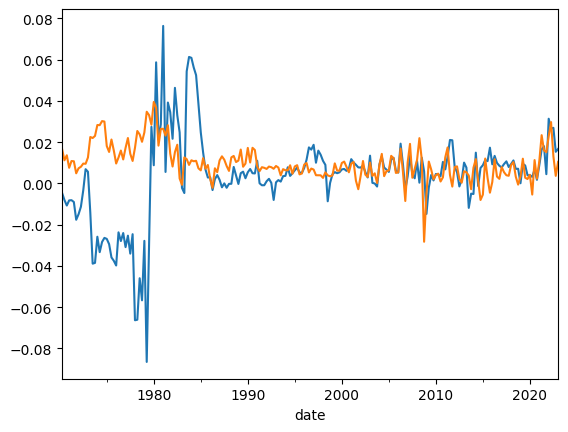

In [10]:
model.stored_state_means["etau"]["United States"].plot()
df_inflation.query("country == 'United States'").set_index("date")["inflation"].plot()

# 4. H-period ahead forecasting

In [11]:
df_inflation

,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


In [12]:
model.predict(df_inflation.query("date <= '2022-10-1'"))

,inflation,country,date
0,-0.005252,Portugal,2023-01-01
1,0.006768,New Zealand,2023-01-01
2,0.009880,Dominican Republic,2023-01-01
3,0.006296,Finland,2023-01-01
4,0.224333,Ireland,2023-01-01
5,0.017543,Austria,2023-01-01
6,0.000234,Japan,2023-01-01
7,0.012873,South Africa,2023-01-01
8,0.012871,Korea,2023-01-01
9,0.006005,Fiji,2023-01-01


In [13]:
from seminartools.models.utils import h_period_ahead_forecast

forecast = h_period_ahead_forecast(model, df_inflation, "2010-01-01", h=1)
forecast

KeyboardInterrupt: 

Text(0.5, 1.0, 'Forecasts, tau and actual inflation for the US')

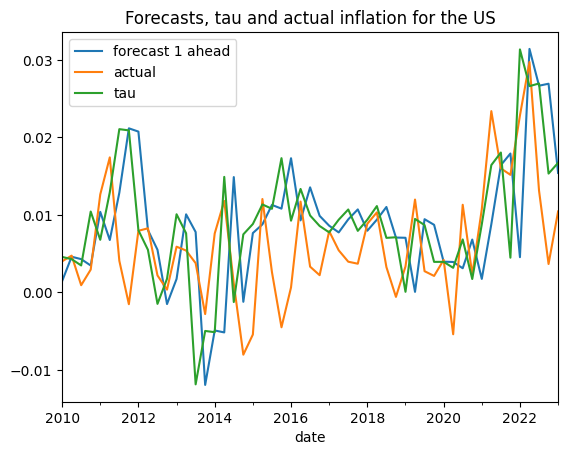

In [ ]:
import matplotlib.pyplot as plt
forecast.query("country == 'United States'").set_index("date")['inflation'].plot(label = "forecast 1 ahead")
df_inflation.query("country == 'United States' and date >= '2010-01-01'").set_index("date")['inflation'].plot(label = "actual")
model.stored_state_means.loc["United States"].loc["2010-01-01":]["etau"].plot(label = "tau")
plt.legend()
plt.title("Forecasts, tau and actual inflation for the US")

Text(0.5, 1.0, 'Tau over time per country')

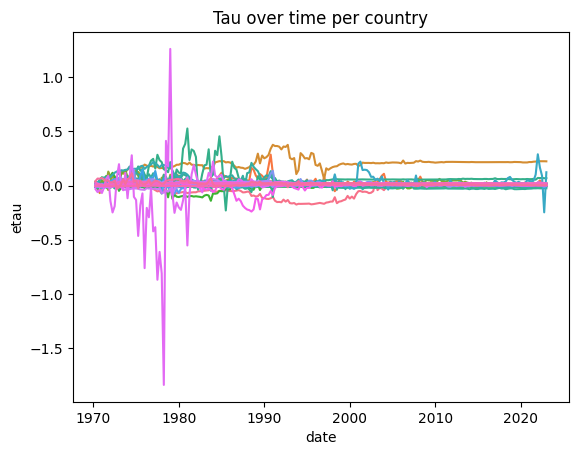

In [ ]:
import seaborn as sns
sns.lineplot(
    data = model.stored_state_means["etau"].to_frame().reset_index(),
    x = "date",
    y = "etau",
    hue = "country"
)
plt.legend().remove()
plt.title("Tau over time per country")

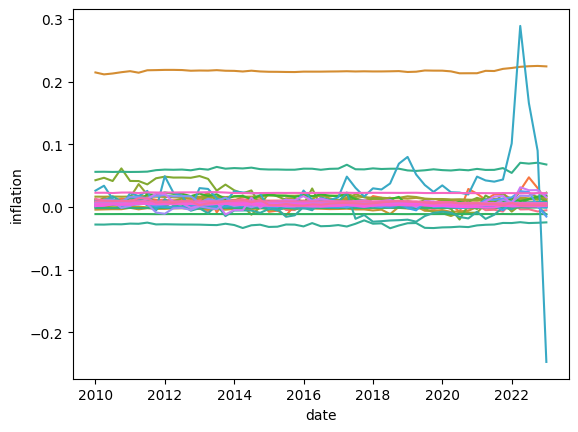

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data = forecast,
    x = "date",
    y = "inflation",
    hue = "country"
)
# turn off legend
plt.legend().remove()

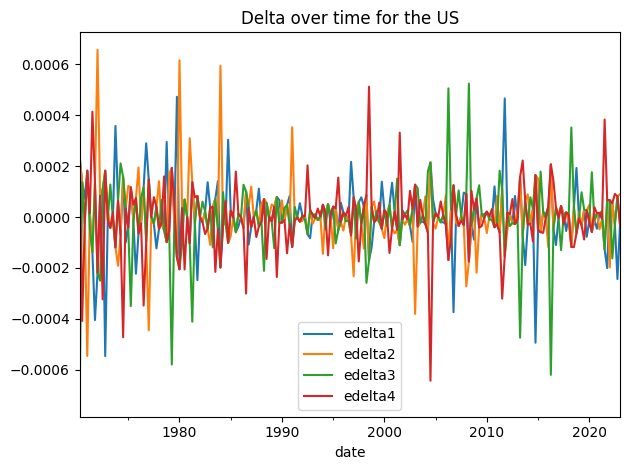

In [ ]:
model.stored_state_means.loc["United States"][["edelta1", "edelta2", "edelta3", "edelta4"]].plot()
plt.title("Delta over time for the US")
plt.tight_layout()
plt.savefig("../../Figures/delta_over_time_mucsvss.png", dpi = 300)

# 5. Compare the forecast with the actual data

In [ ]:
forecast_merged = forecast.copy().rename(columns={"inflation": "pred"})
forecast_merged = forecast_merged.merge(
    df_inflation[["country", "date", "inflation"]],
    on=["country", "date"],
    how="left",
).rename(columns={"inflation": "actual"})
forecast_merged.tail(100)

,pred,country,date,actual
1755,0.013637,Austria,2022-07-01,0.026846
1756,-0.000335,Japan,2022-07-01,0.010628
1757,0.012019,South Africa,2022-07-01,0.027957
1758,0.012643,Korea,2022-07-01,0.011352
1759,0.003679,Fiji,2022-07-01,0.007368
...,...,...,...,...
1850,0.001755,Italy,2023-01-01,0.003938
1851,0.002258,United Kingdom,2023-01-01,0.008814
1852,0.022028,Australia,2023-01-01,0.013756
1853,0.005801,Spain,2023-01-01,0.006013


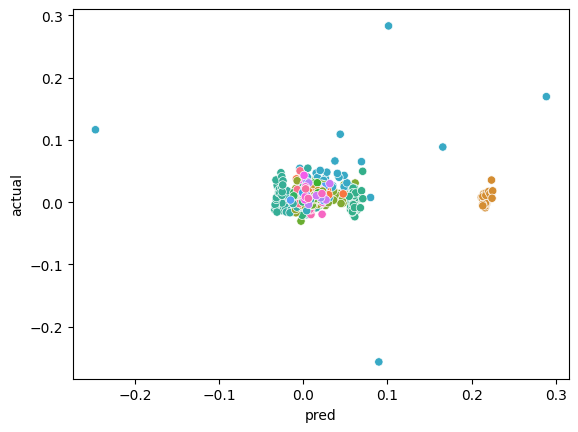

In [ ]:
sns.scatterplot(
    data = forecast_merged,
    x = "pred",
    y = "actual",
    hue = "country"
)
plt.legend().remove()

In [ ]:
import statsmodels.api as sm

sm.OLS(
    forecast_merged["actual"], sm.add_constant(forecast_merged["pred"])
).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 actual   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     2.069
Date:                Fri, 05 Apr 2024   Prob (F-statistic):              0.150
Time:                        10:30:38   Log-Likelihood:                 5256.3
No. Observations:                1855   AIC:                        -1.051e+04
Df Residuals:                    1853   BIC:                        -1.050e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0065      0.000     18.794      0.000       0.006       0.007
pred           0.0122      0.008      1.438      0.150      -0.004       0.029
==============================================================================
Omnibus:                     1397.937   Durbin-Watson:                   1.714
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1745630.190
Skew:                           2.104   Prob(JB):                         0.00
Kurtosis:                     153.224   Cond. No.                         25.6
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

# Fewer countries

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os

# env XLA_FLAGS=--xla_force_host_platform_device_count=12 python foo.py

os.environ['XLA_FLAGS'] = f'--xla_force_host_platform_device_count={os.cpu_count()}'

import jax
jax.config.update('jax_platform_name', 'cpu')
print(jax.devices())
import pandas as pd
from seminartools.data import read_inflation
from seminartools.models.mucsvss_model import MUCSVSSModel
df_inflation = read_inflation(mergeable_format=True).reset_index()
df_inflation

I0000 00:00:1712318632.454325 4069212 tfrt_cpu_pjrt_client.cc:349] TfrtCpuClient created.


[CpuDevice(id=0), CpuDevice(id=1), CpuDevice(id=2), CpuDevice(id=3), CpuDevice(id=4), CpuDevice(id=5), CpuDevice(id=6), CpuDevice(id=7), CpuDevice(id=8), CpuDevice(id=9), CpuDevice(id=10), CpuDevice(id=11), CpuDevice(id=12), CpuDevice(id=13), CpuDevice(id=14), CpuDevice(id=15), CpuDevice(id=16), CpuDevice(id=17), CpuDevice(id=18), CpuDevice(id=19), CpuDevice(id=20), CpuDevice(id=21), CpuDevice(id=22), CpuDevice(id=23)]


,country,date,inflation
0,Portugal,1970-04-01,0.000000
1,New Zealand,1970-04-01,0.015421
2,Dominican Republic,1970-04-01,-0.001604
3,Finland,1970-04-01,0.008333
4,Ireland,1970-04-01,0.029871
...,...,...,...
7415,Canada,2023-01-01,0.006080
7416,Sweden,2023-01-01,0.014955
7417,Korea,2023-01-01,0.010538
7418,United Kingdom,2023-01-01,0.008814


In [3]:
model = MUCSVSSModel(
    # only 30k instead of 100k particles
    num_particles=10008, stochastic_seasonality=True
)
model.full_fit(
    df_inflation[df_inflation["country"].isin([
        "United States",
        # "Netherlands"
    ])]
)

/home/maurits/private/seminar/seminartools/models/mucsvss_model.py:244: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data["pi"] = data[self.inflation_column] * 100
100%|██████████| 212/212 [00:26<00:00,  8.15it/s]


In [4]:
from seminartools.models.utils import h_period_ahead_forecast
forecast = h_period_ahead_forecast(
    model,
    df_inflation[df_inflation["country"].isin(["United States"])],
    "2010-01-01",
    h=1,
)
forecast

,inflation,country,date
0,0.010516,United States,2010-01-01
1,0.005555,United States,2010-04-01
2,0.003084,United States,2010-07-01
3,0.005938,United States,2010-10-01
4,0.009300,United States,2011-01-01
5,0.005080,United States,2011-04-01
6,0.003747,United States,2011-07-01
7,0.007457,United States,2011-10-01
8,0.010682,United States,2012-01-01
9,0.005002,United States,2012-04-01


Text(0.5, 1.0, 'Forecasts, tau and actual inflation for the US')

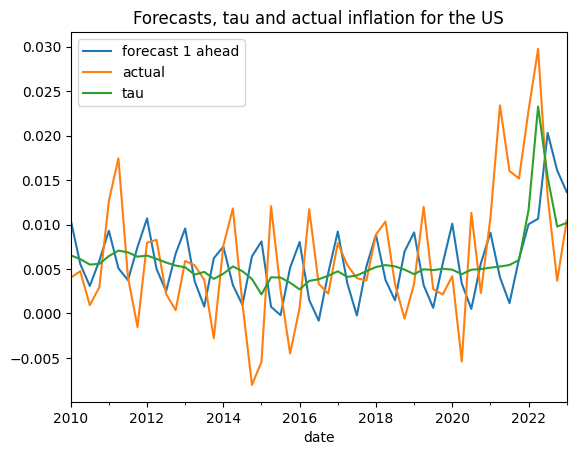

In [5]:
import matplotlib.pyplot as plt
forecast.query("country == 'United States'").set_index("date")['inflation'].plot(label = "forecast 1 ahead")
df_inflation.query("country == 'United States' and date >= '2010-01-01'").set_index("date")['inflation'].plot(label = "actual")
model.stored_state_means.loc["United States"].loc["2010-01-01":]["etau"].plot(label = "tau")
plt.legend()
plt.title("Forecasts, tau and actual inflation for the US")

Text(0.5, 1.0, 'Tau over time per country')

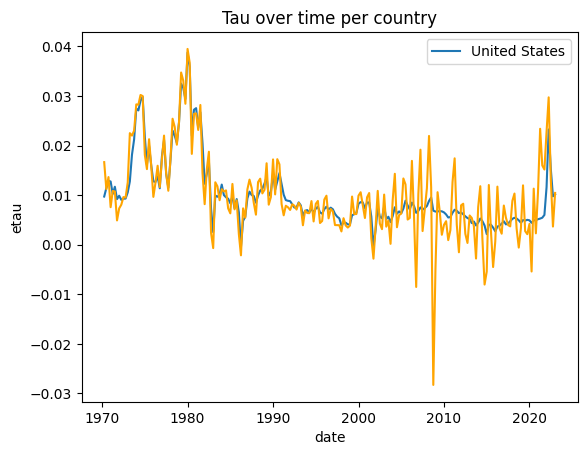

In [8]:
import seaborn as sns
sns.lineplot(
    data = model.stored_state_means["etau"].to_frame().reset_index(),
    x = "date",
    y = "etau",
    hue = "country"
)

sns.lineplot(
    data = model.stored_state_means["inflation"].to_frame().reset_index(),
    x = "date",
    y = "inflation",
    color = "orange"
)
plt.title("Tau over time per country")

<Axes: xlabel='date', ylabel='inflation'>

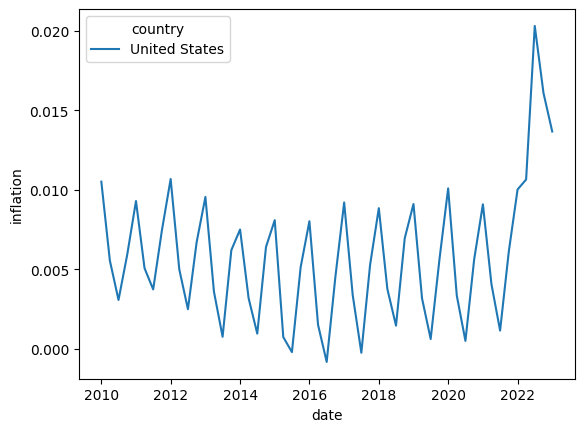

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.lineplot(
    data = forecast,
    x = "date",
    y = "inflation",
    hue = "country"
)
# turn off legend

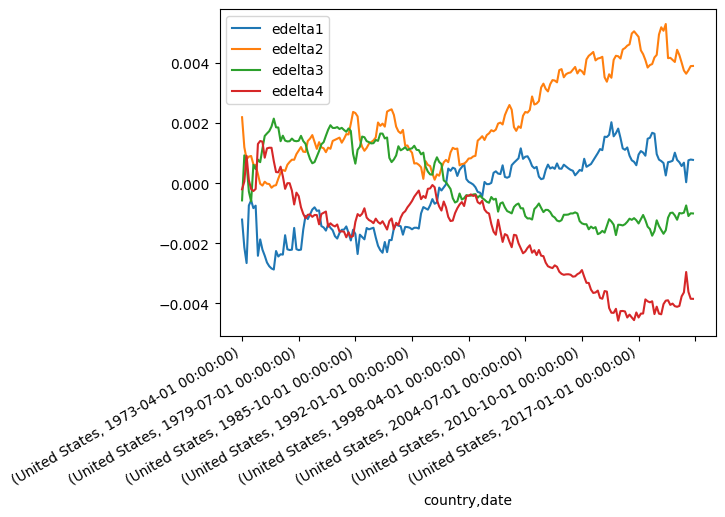

In [10]:
model.stored_state_means.filter(like="edelta").tail(200).plot()
plt.gcf().autofmt_xdate()

In [11]:
model.stored_state_means.head(5).T

country        United States                                            
date              1970-04-01 1970-07-01 1970-10-01 1971-01-01 1971-04-01
etau                0.009722   0.011425   0.012877   0.012761   0.010242
etauplusdeltas     -0.000066   0.008326   0.008028   0.009835   0.017059
elnsetasq          -4.111958  -4.794932  -3.878016  -3.053991  -2.210869
esigmaeta           0.127968   0.090948   0.143847   0.217187   0.331067
elnsepsilonsq      -3.997475  -4.098442  -4.066312  -3.617092  -3.861503
esigmaepsilon       0.135506   0.128835   0.130922   0.163892   0.145039
edelta1            -0.002181  -0.002252  -0.001937  -0.005707  -0.002259
edelta2             0.005506   0.005194   0.003675   0.005677   0.002853
edelta3            -0.001328  -0.000505  -0.001602  -0.000661  -0.001643
edelta4            -0.002042  -0.002494  -0.000012   0.000820   0.001909
meff                0.000000   0.000000   0.000000   0.000000   0.000000
inflation           0.016667   0.011216   0.013652   0.007576   0.010860